# Deep Learning Project 2
**Nina Żukowska 148278**
**Antoni Solarski 148270**

#### Imports

In [1]:
import io
import os
import random
import shutil
import tarfile
import time
import zipfile
from datetime import date
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
from PIL import Image
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# PART 1

---
#### 1) Download the data and load it in the Notebook (5%)

**Note:** The *standard* dataset loading sequence is described below. You can also use *tensorflow_datasets* package for this purpose.

- Download the archive with the dataset
- Create directory "data" and extract downloaded files into
- Implement loading images and labels
- Each image should be represented in the form of numpy.array (shape: (height, width, channels))
- Load all interesting images and labels into two lists or numpy.arrays

**Note:** Watch out for file extensions!

**Step verification:**

Display one of the loaded images, print out the shape of the image, check if the label is correct.

In [2]:
DATA_DIR = 'data/caltech101/'
CALTECH_URL = "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1"

In [3]:
if not os.path.exists(DATA_DIR):
    r = requests.get(CALTECH_URL)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    with tarfile.open("caltech-101/101_ObjectCategories.tar.gz") as file:
        file.extractall()
    os.rename("101_ObjectCategories", "caltech101")
    shutil.move("caltech101", DATA_DIR)
    shutil.rmtree("__MACOSX")
    shutil.rmtree("caltech-101")

In [4]:
def choose_classes(data_path: str, n_classes: int) -> Tuple[List[str], int]:
    classes = []
    for c in os.listdir(data_path):
        if c not in ('BACKGROUND_Google', 'Faces_easy'):
            classes.append((len(os.listdir(os.path.join(data_path, c))), c))

    classes.sort(reverse=True)
    classes = classes[:n_classes]
    samples_min = classes[-1][0]
    classes = [c[1] for c in classes]
    return classes, samples_min

In [5]:
# choose 15 classes with most images
# get minimum number of images in class (samples_min)
N_CLASSES = 15
CLASSES, MIN_SAMPLE = choose_classes(DATA_DIR, N_CLASSES)
print(CLASSES)

['airplanes', 'Motorbikes', 'Faces', 'watch', 'Leopards', 'bonsai', 'car_side', 'ketch', 'chandelier', 'hawksbill', 'grand_piano', 'brain', 'butterfly', 'helicopter', 'menorah']


In [6]:
random.seed(23)


# get only MIN_SAMPLE images (randomly chosen) from each of the chosen classes
# then our classes will be well-balanced

def load_data(data_dir, classes, samples_per_cat=None):
    images, labels = [], []
    for c in classes:
        dir_path = os.path.join(data_dir, c)
        images_in_dir = os.listdir(dir_path)
        if samples_per_cat:
            images_in_dir = random.sample(images_in_dir, samples_per_cat)
        for file in images_in_dir:
            image = Image.open(os.path.join(dir_path, file)).convert('RGB')
            images.append(np.asarray(image))
            labels.append(c)

    return images, labels

In [7]:
IMAGES, LABELS = load_data(DATA_DIR, CLASSES, MIN_SAMPLE)

In [8]:
print(len(IMAGES), len(LABELS))

1305 1305


(141, 398, 3)
airplanes


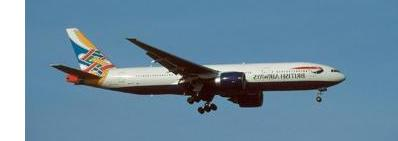

In [50]:
print(IMAGES[0].shape)
print(LABELS[0])
display(Image.fromarray(IMAGES[0]))

---
#### 2) Standardize the images (5%)

**Note:** Some of these operations can be performed during step 1). If that's the case, don't do them again here.

Unify the images:

- Number and sequence of channels (RGB) if needed
- Images shape (e.g. $32 \times 32 \times 3$) - including channel convention (*channels_last* suggested)
- Standardization of pixel values, e.g. ($\frac{x - \mu}{\sigma}$) - calculate $\mu$ and $\sigma$ for the whole dataset, separately for each channel

**Step verification:**

Check what the image you selected in step 1) looks like now.

In [37]:
def resize_images(images):
    resized = np.array([np.asarray(Image.fromarray(i).resize((300, 200))) for i in images])
    return resized


def standardize_images(images):
    images = np.array(images, dtype=np.float32)
    mean = np.mean(images, axis=(0, 1, 2), keepdims=True)
    std = np.std(images, axis=(0, 1, 2), keepdims=True)
    return (images - mean) / std, mean, std


def display_standardized_image(image: np.ndarray, mean, std):
    image = image * std[0] + mean[0]
    image = Image.fromarray(image.astype(np.uint8))
    display(image)

In [38]:
resized_images = resize_images(IMAGES)

(200, 300, 3)
airplanes


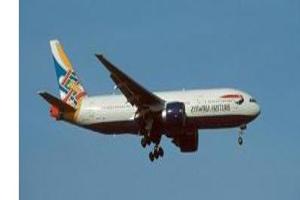

In [39]:
print(resized_images[0].shape)
print(LABELS[0])
display(Image.fromarray(resized_images[0]))

In [40]:
X, MEAN, STD = standardize_images(resized_images)

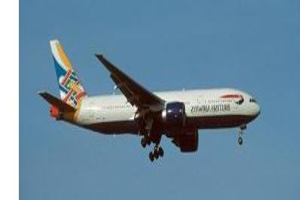

In [41]:
display_standardized_image(X[0], MEAN, STD)

---
#### 3) Divide the collection into Train and Test set (5%)


- Reduce the number of classes - filter the collection and leave images from ~15-25 classes, select those classes that have the largest number of examples. Make sure your collection is balanced (roughly the same number of samples for each class). You can do this by discarding classes that cause imbalance, or you can reduce the number of samples in larger classes.
- Randomly split the set into train (70%) and test (30%) set - X_train, X_test (images) and y_train, y_test (labels). (hint: check *sklearn.model_selection.train_test_split*)
- Make sure that the proportions of each class in both sets are more or less the same as in the whole set (hint: *stratify* parameter in *train_test_split*)
- Change labels in y vectors to one-hot encoding
- Ensure image and label collections are in the form of numpy.array

**Note:** After selecting a subset of classes, check what images contain these classes - are they appropriate for the classification problem? "BACKGROUND_Google" is probably not the best choice :)

**Step verification:**

- Check the shape of the X_train, X_test (images) and the y_train, y_test (labels)
- Check on the example images if the label is in the correct form
- Check how many samples from each class are in particular subsets (train and test) and whether the proportions are the same in both subsets

In [42]:
def one_hot_encoding_for_labels(labels):
    labels_enc = LabelEncoder()
    labels_enc.fit(labels)
    y = labels_enc.transform(labels)

    y = y.reshape((-1, 1))

    labels_ohe = OneHotEncoder()
    labels_ohe.fit(y)
    y = labels_ohe.transform(y)

    return y.toarray(), labels_enc, labels_ohe

In [43]:
y, labels_enc, labels_ohe = one_hot_encoding_for_labels(LABELS)

In [44]:
y.shape, X.shape

((1305, 15), (1305, 200, 300, 3))

In [45]:
X, y

(array([[[[ 1.9068338 ,  1.9524944 ,  1.9283303 ],
          [ 1.9068338 ,  1.9524944 ,  1.9283303 ],
          [ 1.9068338 ,  1.9524944 ,  1.9283303 ],
          ...,
          [ 0.28721783,  0.74283874,  1.0612203 ],
          [ 0.27769068,  0.7330834 ,  1.0515857 ],
          [ 0.2681635 ,  0.7233281 ,  1.0419512 ]],
 
         [[ 1.9068338 ,  1.9524944 ,  1.9283303 ],
          [ 1.9068338 ,  1.9524944 ,  1.9283303 ],
          [ 1.9068338 ,  1.9524944 ,  1.9283303 ],
          ...,
          [ 0.28721783,  0.74283874,  1.0612203 ],
          [ 0.27769068,  0.7330834 ,  1.0515857 ],
          [ 0.2681635 ,  0.7233281 ,  1.0419512 ]],
 
         [[ 1.9068338 ,  1.9524944 ,  1.9283303 ],
          [ 1.9068338 ,  1.9524944 ,  1.9283303 ],
          [ 1.9068338 ,  1.9524944 ,  1.9283303 ],
          ...,
          [ 0.28721783,  0.74283874,  1.0612203 ],
          [ 0.27769068,  0.7330834 ,  1.0515857 ],
          [ 0.2681635 ,  0.7233281 ,  1.0419512 ]],
 
         ...,
 
         [[ 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, random_state=23)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((913, 200, 300, 3), (392, 200, 300, 3), (913, 15), (392, 15))

In [47]:
def resolve_label(label):
    label = labels_ohe.inverse_transform(label.reshape(1, -1))
    label = labels_enc.inverse_transform(label[0])
    return label[0]


def count_samples_in_class(dataset):
    d = {}
    for i in dataset:
        i = resolve_label(i)
        if i not in d:
            d[i] = 1
        else:
            d[i] += 1
    print(d)

In [48]:
count_samples_in_class(y_train)
count_samples_in_class(y_test)

{'Faces': 61, 'hawksbill': 61, 'brain': 61, 'Leopards': 61, 'helicopter': 60, 'butterfly': 61, 'Motorbikes': 61, 'chandelier': 60, 'menorah': 61, 'watch': 61, 'car_side': 61, 'ketch': 61, 'bonsai': 61, 'airplanes': 61, 'grand_piano': 61}
{'ketch': 26, 'menorah': 26, 'brain': 26, 'Leopards': 26, 'grand_piano': 26, 'butterfly': 26, 'hawksbill': 26, 'Faces': 26, 'watch': 26, 'car_side': 26, 'Motorbikes': 26, 'airplanes': 26, 'helicopter': 27, 'chandelier': 27, 'bonsai': 26}


Faces


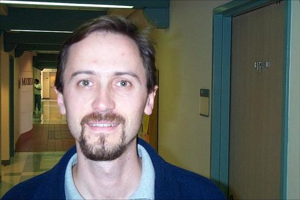

In [51]:
example_img = X_train[0]
print(resolve_label(y_train[0]))
display_standardized_image(example_img, MEAN, STD)

---
#### 4) Define the model (5%)

Suggestions (you should probably try different settings and choose the *best* one):

- Activation functions - *ReLU*
- At least 3 *Convolutional blocks* - (Conv2D, Activation, BatchNormalization, Dropout, MaxPooling2D); Conv2D - *kernel=(3,3)*, *padding='same'*; MaxPooling2D - *pool_size=(2,2)*
- Flatten layer
- At least 2 layers Fully-Connected (Dense)
- Output layer - Dense with number_of_classes outputs (remember to use softmax)

**Note:** You can add *Activation* as a separate layer or as *activation='relu'* parameter in Conv2D

**Step verification:**

Compile the model with *'adam'* optimizer, the Categorical Crossentropy as the loss function, and measure the accuracy value.

In [68]:
def get_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(200, 300, 3)),

        tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation='relu'),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation='relu'),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation='relu'),
        tf.keras.layers.MaxPool2D((2, 2)),

        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu'),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu'),
        tf.keras.layers.MaxPool2D((2, 2)),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(15, activation="softmax")
    ])
    model.compile(optimizer='Adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    return model

In [69]:
model = get_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 200, 300, 16)      448       
                                                                 
 conv2d_10 (Conv2D)          (None, 200, 300, 16)      2320      
                                                                 
 conv2d_11 (Conv2D)          (None, 200, 300, 16)      2320      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 100, 150, 16)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 100, 150, 32)      4640      
                                                                 
 conv2d_13 (Conv2D)          (None, 100, 150, 32)      9248      
                                                      

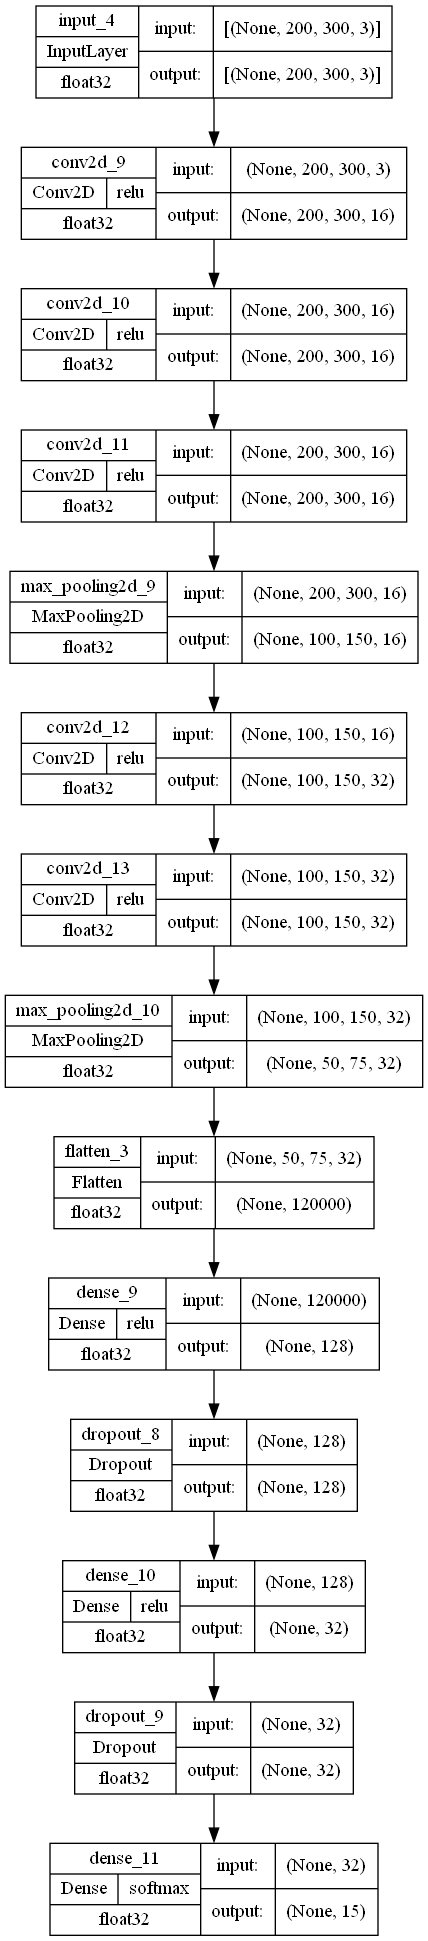

In [70]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_activations=True)

---
#### 5) Train the model (5%)

Suggested hyperparameters:

- batch_size = 32
- epochs = 250 (or whatever you think is appropriate; first, just check if everything works on several epochs to save time)
- Monitor the value of measures for the test set
- Add [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - stop training when there is no improvement in accuracy for the test set within 5 consecutive epochs (you can first test the behavior for patience = 1)

**Step verification:**

After completing the learning process, show:

- Learning curves for loss_function and accuracy, changing over the epochs on train and test set
- Confusion matrix and calculate precision and recall for each class for test set
- Show few images from the test set, display the probabilities of assigning them to each class (at least two examples: one image example that was classified correctly and one which was classified incorrectly)

**Note:** Functions to display learning curves and confusion matrices based on the model will be useful in the Part 2.

In [73]:
def train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=patience,
                                                      restore_best_weights=True)
    return model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                     callbacks=[early_stopping])

In [74]:
EPOCHS = 250
BATCH_SIZE = 32
history = train_model(model, X_train, y_train, X_test, y_test, EPOCHS, BATCH_SIZE)

Epoch 1/250
29/29 [==============================] - 45s 2s/step - loss: 2.7155 - accuracy: 0.0723 - val_loss: 2.7052 - val_accuracy: 0.1071
Epoch 2/250
29/29 [==============================] - 43s 1s/step - loss: 2.6988 - accuracy: 0.0876 - val_loss: 2.6716 - val_accuracy: 0.1097
Epoch 3/250
29/29 [==============================] - 44s 2s/step - loss: 2.6969 - accuracy: 0.0887 - val_loss: 2.6613 - val_accuracy: 0.1403
Epoch 4/250
29/29 [==============================] - 42s 1s/step - loss: 2.6595 - accuracy: 0.0975 - val_loss: 2.5605 - val_accuracy: 0.2117
Epoch 5/250
29/29 [==============================] - 43s 1s/step - loss: 2.4889 - accuracy: 0.1763 - val_loss: 2.3647 - val_accuracy: 0.3010
Epoch 6/250
29/29 [==============================] - 43s 1s/step - loss: 2.3467 - accuracy: 0.2497 - val_loss: 2.0447 - val_accuracy: 0.4821
Epoch 7/250
29/29 [==============================] - 43s 1s/step - loss: 2.0900 - accuracy: 0.3253 - val_loss: 1.7674 - val_accuracy: 0.5255
Epoch 8/250
2

In [75]:
# test the model
MODEL_EVAL = model.evaluate(X_test, y_test)

13/13 [==============================] - 3s 233ms/step - loss: 0.9207 - accuracy: 0.7704


In [76]:
# get predictions
y_test_raw_predictions = model.predict(X_test)
y_test_predictions = np.asarray(tf.argmax(y_test_raw_predictions.T))
y_test_true = labels_ohe.inverse_transform(y_test).reshape((1, -1))[0]

13/13 [==============================] - 3s 234ms/step


In [77]:
y_test_true_labels = labels_enc.inverse_transform([i for i in y_test_true])
y_test_predictions_labels = labels_enc.inverse_transform([i for i in y_test_predictions])

In [78]:
def plot_metrics_from_model_history(history, metric: str):
    plt.plot(history.epoch, history.history[metric], 'g', label=f'{metric} on training set')
    plt.plot(history.epoch, history.history['val_' + metric], 'r', label=f'{metric} on test set')
    plt.title(f'Training {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

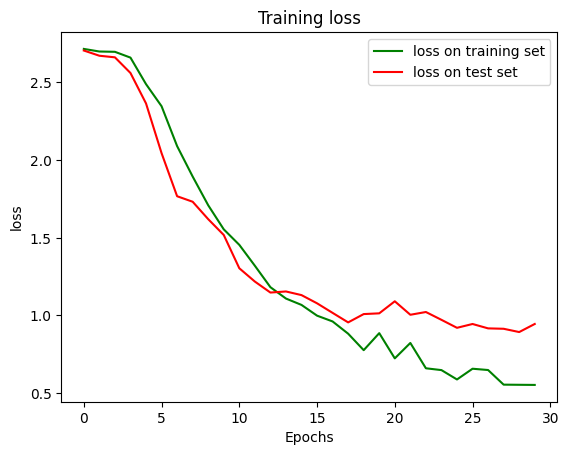

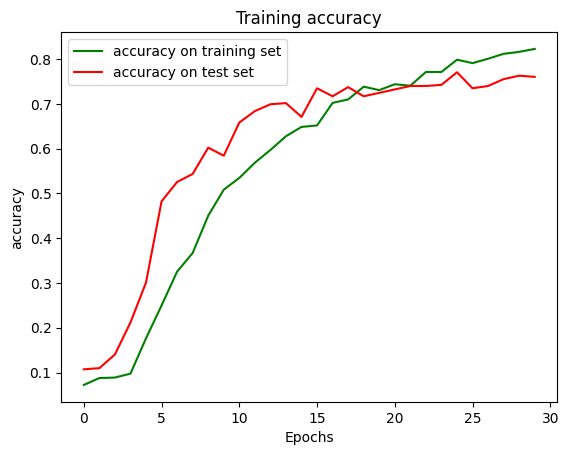

In [79]:
plot_metrics_from_model_history(history, 'loss')
plot_metrics_from_model_history(history, 'accuracy')

In [80]:
def plot_confusion_matrix(confusion_matrix, labels):
    fig = plt.figure(figsize=(10, 12))
    ax = fig.add_subplot()
    cax = ax.matshow(confusion_matrix, interpolation='nearest', cmap='Blues')
    fig.colorbar(cax)
    ax.set_xlabel('predicted')
    ax.set_ylabel('true')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    ax.tick_params(axis='both', which='major', labelsize=15)

    plt.show()

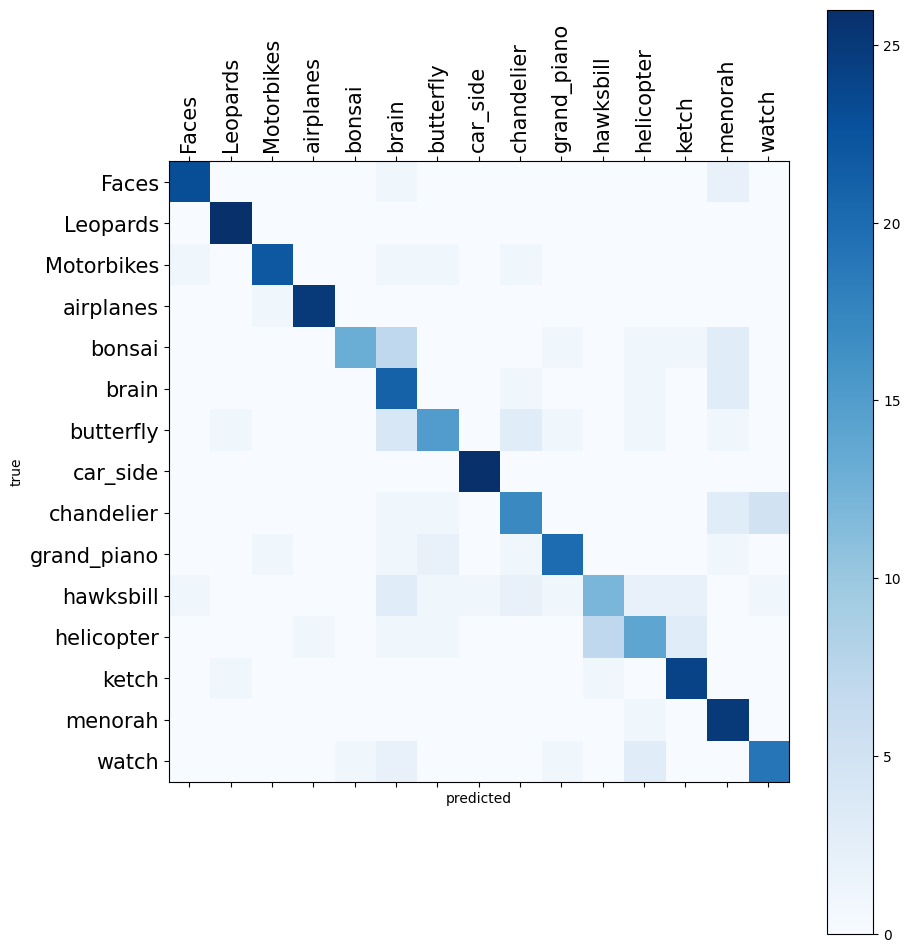

In [81]:
confusion_matrix = tf.math.confusion_matrix(y_test_true, y_test_predictions)
plot_confusion_matrix(confusion_matrix, labels_enc.inverse_transform([i for i in range(N_CLASSES)]))

In [82]:
report = classification_report(y_test_true_labels, y_test_predictions_labels, zero_division=0)
print(report)

              precision    recall  f1-score   support

       Faces       0.92      0.88      0.90        26
    Leopards       0.93      1.00      0.96        26
  Motorbikes       0.92      0.85      0.88        26
   airplanes       0.96      0.96      0.96        26
      bonsai       0.93      0.50      0.65        26
       brain       0.50      0.81      0.62        26
   butterfly       0.71      0.58      0.64        26
    car_side       0.96      1.00      0.98        26
  chandelier       0.68      0.63      0.65        27
 grand_piano       0.83      0.77      0.80        26
   hawksbill       0.60      0.46      0.52        26
  helicopter       0.61      0.52      0.56        27
       ketch       0.80      0.92      0.86        26
     menorah       0.66      0.96      0.78        26
       watch       0.76      0.73      0.75        26

    accuracy                           0.77       392
   macro avg       0.78      0.77      0.77       392
weighted avg       0.78   

In [83]:
def show_classification_example(raw_predictions, img, prediction_label, true_label, ):
    pp = {labels_enc.inverse_transform([i])[0]: pi for i, pi in enumerate(raw_predictions)}
    if prediction_label == true_label:
        print(f"{prediction_label} correctly classified")
    else:
        print(f"{true_label} classified as {prediction_label}")
    display_standardized_image(img, MEAN, STD)
    print("probabilities:")
    for i, pi in sorted(pp.items(), key=lambda x: x[1], reverse=True):
        print(f"{i}: {pi}")

In [84]:
c_idx, w_idx = None, None
for i, (ti, pi) in enumerate(zip(y_test_true, y_test_predictions)):
    if ti == pi:
        c_idx = i
    if ti != pi:
        w_idx = i
    if c_idx and w_idx:
        break

grand_piano correctly classified


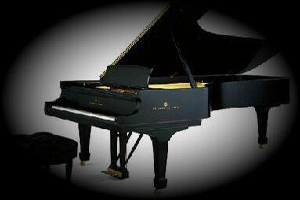

probabilities:
grand_piano: 0.9918650984764099
butterfly: 0.007686268072575331
helicopter: 0.00024115137057378888
brain: 0.00016356800915673375
menorah: 1.403844726155512e-05
chandelier: 1.3148468497092836e-05
Motorbikes: 7.269560228451155e-06
watch: 5.633721229969524e-06
Leopards: 1.673458427831065e-06
Faces: 8.41667542772484e-07
bonsai: 6.049996841284155e-07
airplanes: 3.037763462998555e-07
ketch: 2.5364016664752853e-07
hawksbill: 3.775432233510401e-08
car_side: 9.523727584337394e-09


In [85]:
show_classification_example(y_test_raw_predictions[c_idx], X_test[c_idx], y_test_predictions_labels[c_idx],
                            y_test_true_labels[c_idx])

watch classified as helicopter


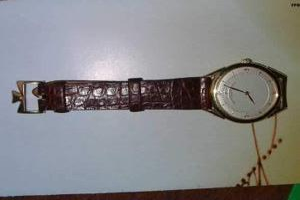

probabilities:
helicopter: 0.21575459837913513
watch: 0.20333249866962433
grand_piano: 0.16107481718063354
brain: 0.07198180258274078
butterfly: 0.06631416827440262
menorah: 0.06435669958591461
Motorbikes: 0.05244053155183792
chandelier: 0.03063730150461197
bonsai: 0.027531208470463753
airplanes: 0.02014276199042797
Faces: 0.01881563290953636
ketch: 0.017406411468982697
Leopards: 0.01739390939474106
car_side: 0.016690930351614952
hawksbill: 0.016126757487654686


In [86]:
show_classification_example(y_test_raw_predictions[w_idx], X_test[w_idx], y_test_predictions_labels[w_idx],
                            y_test_true_labels[w_idx])

---
#### 6) Save the model to disk (5%)
- Prepare 2 functions - for saving the model and for loading the model
- Model structure should be saved as JSON file, model parameters in HDF5 file

**Step verification:**

Checking the operation of both functions by:

- Save the model
- Load the model
- Make predictions on the loaded model for the test set
- Display the confusion matrix for the test set and compare it with the matrix obtained in the previous step to see if saving and loading worked properly

In [87]:
def save_model(model, prefix):
    model_path = f'models/{prefix}-{date.today()}'
    model.save(model_path)
    return model_path

In [88]:
model_path = save_model(model, int(MODEL_EVAL[1] * 100))

INFO:tensorflow:Assets written to: models/77-2023-01-16\assets


INFO:tensorflow:Assets written to: models/77-2023-01-16\assets


In [89]:
loaded_model = tf.keras.models.load_model(model_path)
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 200, 300, 16)      448       
                                                                 
 conv2d_10 (Conv2D)          (None, 200, 300, 16)      2320      
                                                                 
 conv2d_11 (Conv2D)          (None, 200, 300, 16)      2320      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 100, 150, 16)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 100, 150, 32)      4640      
                                                                 
 conv2d_13 (Conv2D)          (None, 100, 150, 32)      9248      
                                                      

In [90]:
loaded_model.evaluate(X_test, y_test)

13/13 [==============================] - 3s 232ms/step - loss: 0.9207 - accuracy: 0.7704


[0.9206514954566956, 0.7704081535339355]

13/13 [==============================] - 3s 234ms/step


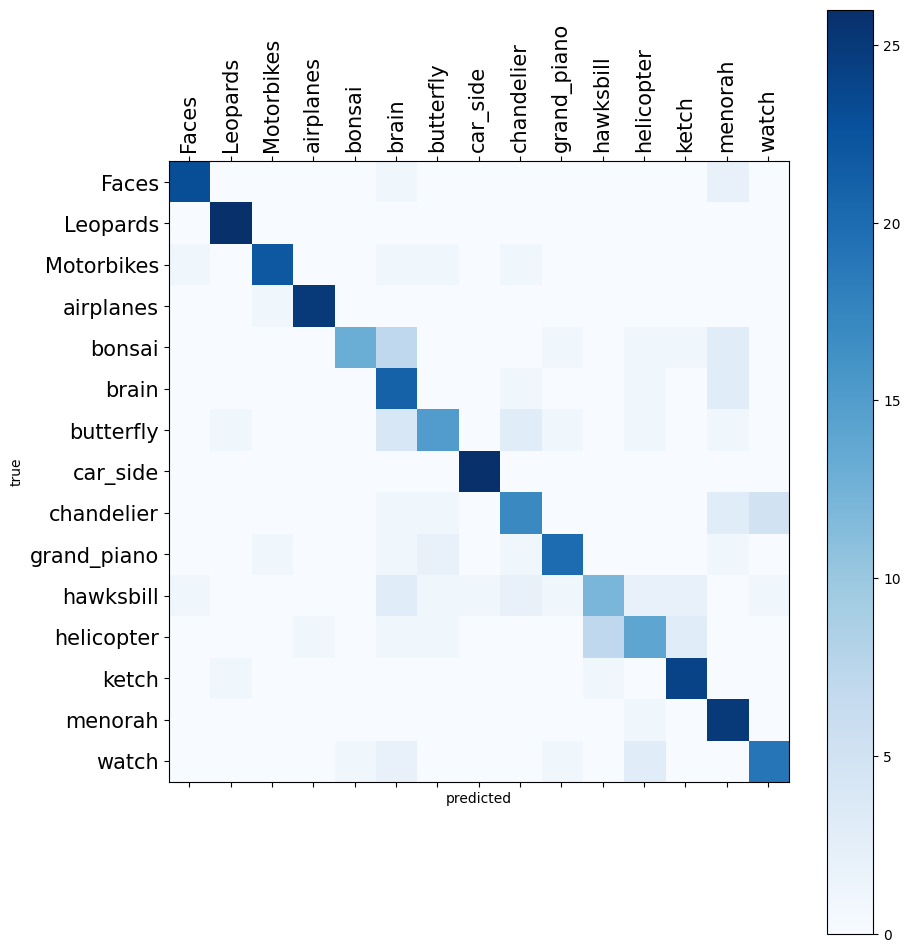

In [91]:
loaded_model_predictions = np.asarray(tf.argmax(loaded_model.predict(X_test).T))
confusion_matrix = tf.math.confusion_matrix(y_test_true, loaded_model_predictions)
plot_confusion_matrix(confusion_matrix, labels_enc.inverse_transform([i for i in range(N_CLASSES)]))

---
#### 7) Summary of the Part 1 - describe your observations (10%)

Describe your observations on the tasks performed. Supporting questions:

- What kind of modifications have you made? Why? (*Describe, if you made any*)
- What results have you achieved?
- Is the underfitting or overfitting of the model visible? If so, what are your suggestions for solving this problem?
- Which class(es) the model had a trouble with? Which were the easiest for it? Which pair of classes were most often confused with each other? Can you guess why?
- What opportunities do you see for improvement?

**Step verification:**

Use Markdowns to describe your conclusions or put them into the report.

##### Results discussion
We got **77% accuracy** on the test set with a pretty small model (**15,383,727 parameters**). Given the number of **classes (15)** and the relatively small dataset (**913 images** in the training set), we consider the obtained accuracy to be quite good.

##### Overfitting obstacles
Initially, we faced pretty big overfitting, with about 99% accuracy on the training set and 60% on the test set. But after adding dropout (0.5, only in dense layers, as it's suggested by [Hinton](https://arxiv.org/pdf/1207.0580.pdf)) and changing the early stopping condition to track validation statistics instead of training ones, we overcome overfitting problems.

##### (Non)problematic classes
Our model performed best in the *car_side*, *leopards*, and *airplanes* classes, with over 0.95 F1-scores in each of these categories.It had a difficult time classifying images like "hawksbill," "helikopter," and "brain."We can see that *hawksbill* is often classified as another object what resulted in poor **recall** (possible explanation is that the hawksbill (sea turtle) looks much different from the top and side view). Another problem is connected to *brain* class - other object were often misclassified as *brain*, this resulted in pretty good recall but poor **accuracy**.

We can derive interesting observation from the example results produced by model and presented above. One can see that *grand_piano* was classified correctly with almost 99% confidence, while misclassified *watch* was classified as *helicopter* only by small probability difference (0.21 vs 0.22).

##### Possible improvements
- We saw one possible data leakage. We did standardization on the whole set of images (before dividing it into the training and test sets). Calculation of statistics on the whole dataset is usually not recommended, because these may differ between the training and test sets and should be calculated after the split. On the other hand, in our case, we don't expect any significant statistical differences between images in different sets.
- We could consider adding the dropout for convolutional blocks as well. As [newer research](http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf) suggests small dropout rates (0.1 or 0.2) on convolutional layers can improve quality of the results.
- We could consider adding using [cost-sensitive learning](https://www.researchgate.net/publication/2365611_The_Foundations_of_Cost-Sensitive_Learning) adding greater punishments for most problematic classes (like *brain* in our case).

# PART 2

---
#### 4) Compare the models without and with regularization (L1, L2, L1 + L2)

In [44]:
# TODO

#### Findings

In [3]:
# TODO

---
#### 11) Training with different batch sizes (e.g. 1, 16, 32, number_of_samples)

In [60]:
def batch_size_experiment(batch_size):
    m = get_model()
    start_time = time.time()
    h = train_model(m, X_train, y_train, X_test, y_test, 2, batch_size)
    end_time = time.time()
    _, acc = m.evaluate(X_test, y_test)
    return m, h, acc, end_time - start_time

Epoch 1/2
913/913 [==============================] - 62s 66ms/step - loss: 2.4155 - accuracy: 0.2475 - val_loss: 1.9892 - val_accuracy: 0.4362
Epoch 2/2
13/13 [==============================] - 2s 125ms/step - loss: 1.6473 - accuracy: 0.5459
Epoch 1/2
58/58 [==============================] - 23s 381ms/step - loss: 2.6478 - accuracy: 0.1950 - val_loss: 2.1142 - val_accuracy: 0.3469
Epoch 2/2
13/13 [==============================] - 2s 124ms/step - loss: 1.5526 - accuracy: 0.5230
Epoch 1/2
29/29 [==============================] - 21s 690ms/step - loss: 2.6420 - accuracy: 0.1533 - val_loss: 2.0118 - val_accuracy: 0.3827
Epoch 2/2
13/13 [==============================] - 2s 132ms/step - loss: 1.3709 - accuracy: 0.5791
Epoch 1/2
1/1 [==============================] - 21s 21s/step - loss: 2.7233 - accuracy: 0.0405 - val_loss: 3.6711 - val_accuracy: 0.0663
Epoch 2/2
13/13 [==============================] - 2s 130ms/step - loss: 2.8395 - accuracy: 0.1301
Training with batch sizes 1 took 122.09

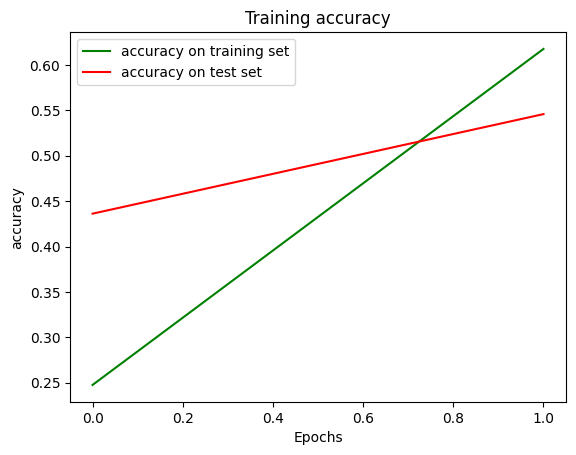

Training with batch sizes 16 took 44.39500284194946.
Obtained accuracy: 0.5229591727256775


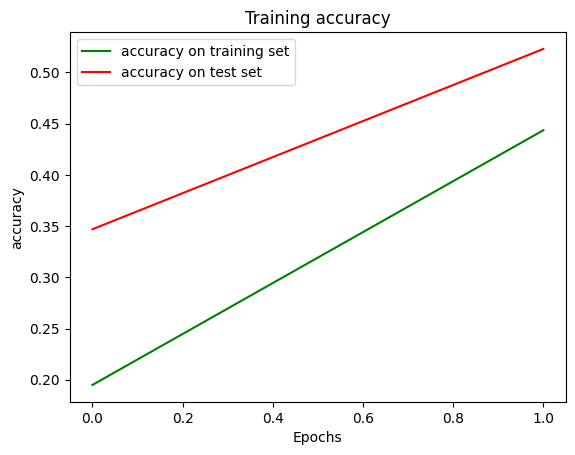

Training with batch sizes 32 took 40.4935028553009.
Obtained accuracy: 0.579081654548645


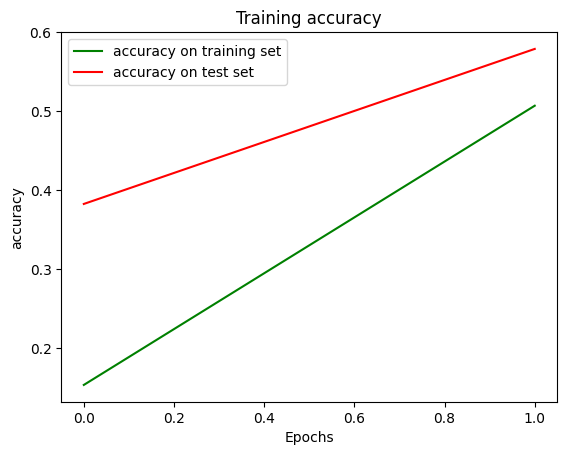

Training with batch sizes 913 took 38.92187690734863.
Obtained accuracy: 0.1301020383834839


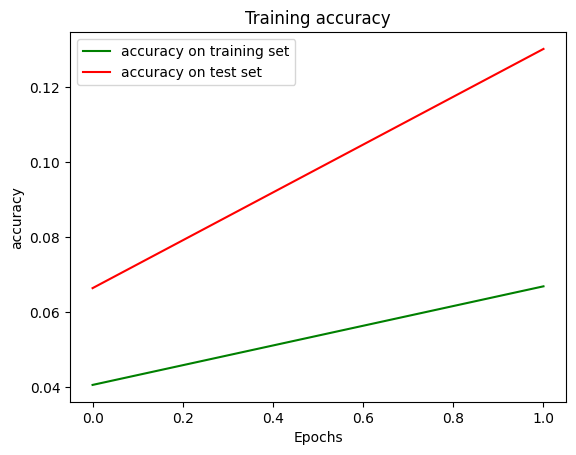

In [61]:
BATCH_SIZES = (1, 16, 32, len(X_train))
results = {bs: batch_size_experiment(bs) for bs in BATCH_SIZES}

In [1]:
for batch_size, (m, h, acc, t) in results.items():
    print(f'Training with batch sizes {batch_size} took {t}.')
    print(f'Obtained accuracy: {acc}')
    plot_metrics_from_model_history(h, 'accuracy')

NameError: name 'results' is not defined

#### Findings

In [2]:
# TODO

---
#### 12) Training for unbalanced datasets  (Task double scored, worth 40%)
- Take one class with a lot of samples (e.g. in Caltech101 - airplanes with 800 samples) and 1 or several classes with significantly fewer samples (e.g. 1 class with ~80 samples or 5 classes with ~30 samples per class)
- Split the dataset proportionally in the Train and Test set
- Train the default model - what was your accuracy, precision, recall?
- Check what values would you get if you made a simple decision rule model which always classifies samples into the most numerous class? Is your model clearly better than it or has it achieved quite similar results?
- Find information about traning on the imbalanced dataset and how to deal with that problem e.g. change loss function, change quality measures, check how you can modify dataset
- Apply the changes and check if you managed to get a better model
- Describe your strategy for solving problems related to this issue

In [46]:
# TODO

#### Findings

In [ ]:
# TODO